# "A neural network for elastography (part 2)"
> "Let's train a neural network to solve a (slightly more realistic) typical problem encountered in elastography"

- toc: true
- badges: true
- comments: false
- categories: [elastography]
- author: Lucas Almeida Rocha

## Introduction

In part 1, we talked about elastography and we created a model that predicts the stiffness from a given displacement field. The displacement field had no noise, so we decided to add some to make it looks more real. Our goal is to beat that model.

Introduction and Data Prepration sections will be almost identical to part 1, so we won't comment much about it. For details, check part 1. 

Let's code! First, if you're using colab, you need to install [PyTorch](https://pytorch.org/) and [fastai](https://www.fast.ai/).

In [ ]:
!pip install torch
!pip install fastai
!pip install fastai --upgrade -q

Then, we download and unzip the data, we're going to use.

In [ ]:
import os.path
if not os.path.exists('MNIST_input_files.zip'):
  !wget https://open.bu.edu/bitstream/handle/2144/38693/MNIST_input_files.zip

if not os.path.exists('FEA_displacement_results_step5.zip'):
  !wget https://open.bu.edu/bitstream/handle/2144/38693/FEA_displacement_results_step5.zip

!unzip -n "MNIST_input_files.zip" -d "."
!unzip -n "FEA_displacement_results_step5.zip" -d "uniaxial/"

We import some libraries.

In [ ]:
import pandas as pd
import torch
from fastai.vision.all import *

## Data preparation

We load the data from text files to pytorch tensor.

In [ ]:
df = pd.read_csv('MNIST_input_files/mnist_img_train.txt', sep=' ', header=None)
imgs_train = torch.tensor(df.values)

df = pd.read_csv('MNIST_input_files/mnist_img_test.txt', sep=' ', header=None)
imgs_valid = torch.tensor(df.values)

imgs_train.shape, imgs_valid.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [ ]:
df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispx_train_step5.txt', sep=' ', header=None)
ux5s_train = torch.tensor(df.values)

df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispy_train_step5.txt', sep=' ', header=None)
uy5s_train = torch.tensor(df.values)

df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispx_test_step5.txt', sep=' ', header=None)
ux5s_valid = torch.tensor(df.values)

df = pd.read_csv('uniaxial/FEA_displacement_results_step5/summary_dispy_test_step5.txt', sep=' ', header=None)
uy5s_valid = torch.tensor(df.values)


ux5s_train.shape, uy5s_train.shape, ux5s_valid.shape, uy5s_valid.shape

(torch.Size([60000, 784]),
 torch.Size([60000, 784]),
 torch.Size([10000, 784]),
 torch.Size([10000, 784]))

We reshape the data.

In [ ]:
ux5s_train = torch.reshape(ux5s_train, (-1,1,28,28))
uy5s_train = torch.reshape(uy5s_train, (-1,1,28,28))
ux5s_valid = torch.reshape(ux5s_valid, (-1,1,28,28))
uy5s_valid = torch.reshape(uy5s_valid, (-1,1,28,28))

imgs_train = torch.reshape(imgs_train, (-1,1,28,28))
imgs_valid = torch.reshape(imgs_valid, (-1,1,28,28))

ux5s_train.shape, uy5s_train.shape, ux5s_valid.shape, uy5s_valid.shape, imgs_train.shape, imgs_valid.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]))

The displacement field is inverted, so we fix it.

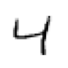

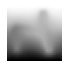

In [ ]:
show_image(imgs_train[2], cmap='Greys')
show_image(uy5s_train[2], cmap='Greys')

In [ ]:
ux5s_train = torch.flip(ux5s_train, dims=[1,2])
uy5s_train = torch.flip(uy5s_train, dims=[1,2])
ux5s_valid = torch.flip(ux5s_valid, dims=[1,2])
uy5s_valid = torch.flip(uy5s_valid, dims=[1,2])

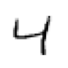

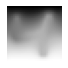

In [ ]:
show_image(imgs_train[2], cmap='Greys')
show_image(uy5s_train[2], cmap='Greys')

We convert from pixel values to stiffness.

In [ ]:
imgs_train = (imgs_train / 255.) * 99. + 1.
imgs_valid = (imgs_valid / 255.) * 99. + 1.

imgs_train = imgs_train / 100.
imgs_valid = imgs_valid / 100.

In [ ]:
imgs_train.min(), imgs_valid.min(), imgs_train.max(), imgs_valid.max()

(tensor(0.0100), tensor(0.0100), tensor(1.), tensor(1.))

We put horizontal and vertical displacements into the same tensor.

In [ ]:
us_train = torch.cat([ux5s_train, uy5s_train], dim=1)
us_valid = torch.cat([ux5s_valid, uy5s_valid], dim=1)

us_train.shape, us_valid.shape

(torch.Size([60000, 2, 28, 28]), torch.Size([10000, 2, 28, 28]))

We do some cleaning.

In [ ]:
del ux5s_train; del uy5s_train; del ux5s_valid; del uy5s_valid

Okay, now we have some new stuff.

This fastai Transform is the same from part 1, except by the fact that it adds some noise. The noise will be taken from a [Normal Distribution](https://en.wikipedia.org/wiki/Normal_distribution) with mean equals to 0 and standard deviation equals to 0.1. We will see that the noise makes the task more challenging.

In [ ]:
class GetNormalizedData(Transform):
  def __init__(self, us, imgs, mean, std, noise_std):
    self.us, self.imgs = us, imgs
    self.mean, self.std = mean, std
    self.noise_std = noise_std

  def encodes(self, i):
    us_norm = torch.true_divide((self.us[i] - self.mean.view(2,1,1)), self.std.view(2,1,1))
    us_with_noise = us_norm + torch.randn(2,28,28)*self.noise_std
    return (us_with_noise.float(), self.imgs[i].float())

We calculate the mean and standard deviation from our dataset, so we can normalize the data.

In [ ]:
us_mean = torch.mean(us_train, dim=[0,2,3])
us_std = torch.std(us_train, dim=[0,2,3])

We create fastai TfmdLists and DataLoaders.

In [ ]:
noise_std = 0.1
train_tl= TfmdLists(range(len(us_train[:])), 
                    GetNormalizedData(us_train[:], imgs_train[:], us_mean, us_std, noise_std)
                    )

valid_tl= TfmdLists(range(len(us_valid[:])), 
                    GetNormalizedData(us_valid[:], imgs_valid[:], us_mean, us_std, noise_std)
                    )

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64)
                             
if torch.cuda.is_available(): dls = dls.cuda()

Okay, let's take a look in our batch.

In [ ]:
x,y = dls.one_batch()
x.shape, y.shape, x.mean(), x.std()

(torch.Size([64, 2, 28, 28]),
 torch.Size([64, 1, 28, 28]),
 tensor(-0.0054),
 tensor(1.0122))

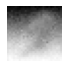

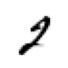

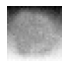

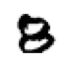

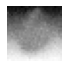

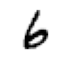

In [ ]:
show_image(x[0][1], cmap='Greys')
show_image(y[0], cmap='Greys')
show_image(x[1][1], cmap='Greys')
show_image(y[1], cmap='Greys')
show_image(x[2][1], cmap='Greys')
show_image(y[2], cmap='Greys')

We can still identify the numbers in the displacement field, but the details are very difficult to see.

## Training


Remember, our goal is to beat the model created in part 1. That model got a validation loss of 0.0065, so that's our goal. The task now is definitely more difficult, so we will use a deeper neural network.

We will not train it all at once (we probably could, try it). We begin training the same model we used in part 1. Then, we remove the output layer and add a new hidden layer and a new output layer. We train the two new layers and then, we train the whole model. After that, we repeat the process of removing/adding layers and training them.

We create a class `Base`, which will be the input/hidden layer, and a class `Head`, which will be the output layer. We multiply the activations by 1.1 after the sigmoid, so the model returns values between 0 and 1.1.

In [ ]:
class Base(nn.Module):
  def __init__(self, n_in, n_out):
    super(Base, self).__init__()
    self.conv = nn.Conv2d(n_in, n_out, kernel_size=5, stride=1, padding=2, padding_mode='reflect', bias=True)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    return self.relu(self.conv(x))

In [ ]:
class Head(nn.Module):
  def __init__(self, n_in, n_out, y_range):
    super(Head, self).__init__()
    self.y_range = y_range
    self.conv = nn.Conv2d(n_in, n_out, 5, 1, 2, padding_mode='reflect', bias=True)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    return self.sigmoid(self.conv(x))*self.y_range

We begin with the same architecture used in part 1.

In [ ]:
cnn1 = nn.Sequential(Base(2, 4), Head(4, 1, 1.1))

In [ ]:
l1 = Learner(dls, cnn1, loss_func=F.mse_loss, model_dir='')

We find a good candidate for learning rate and then we train the model.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.010964781977236271)

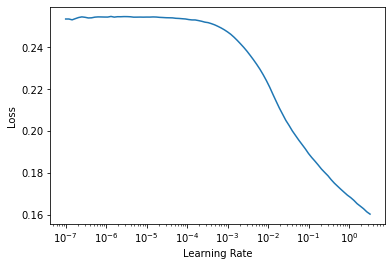

In [ ]:
l1.lr_find()

In [ ]:
l1.fit_one_cycle(10,lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.024701,0.023902,00:18
1,0.020117,0.019674,00:18
2,0.019051,0.018667,00:18
3,0.018855,0.018620,00:18
4,0.018318,0.018213,00:18
5,0.017984,0.018009,00:18
6,0.017937,0.017854,00:18
7,0.017773,0.017722,00:18
8,0.017673,0.017584,00:19
9,0.017758,0.017525,00:19


We can save it.

In [ ]:
l1.path = Path('')

l1.save('02_cnn1_ep10')

Let's see how our model is doing.

In [ ]:
preds, targets, losses = l1.get_preds(with_loss=True)

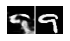

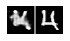

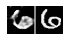

In [ ]:
_, indices = torch.sort(losses, descending=True)

for i in indices[:3]:
  show_image(torch.cat([preds, torch.ones(preds.shape[0],1,28,1), targets], dim=3)[i], cmap='Greys_r')

In [ ]:
I_preds = ((preds*100)-1)*(255/99)
I_targets = ((targets*100)-1)*(255/99)

I_error = torch.abs(I_preds - I_targets)

I_mean = torch.mean(I_error)
I_std = torch.std(I_error)

I_mean, I_std

(tensor(14.6327), tensor(30.8624))

Mean and standard deviation are 14.6 and 30.9, respectively. It does not seem terrible, but we are still far from our goal. Let's add more layers.

We take the first layer of our previous model and add two new layers.

In [ ]:
cnn2 = nn.Sequential(l1.model[0], Base(4, 8), Head(8, 1, 1.1))
l2 = Learner(dls, cnn2, loss_func=F.mse_loss, model_dir='')

Now we want to train only the newly added layers, so we "freeze" all layers but the last two. This is a funcionality of fastai, that allow us to choose which layer we wish to train. A frozen layer don't have its parameters updated when training.

In [ ]:
l2.freeze_to(-2)

Now we find a good learning rate and train our model.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0012022644514217973)

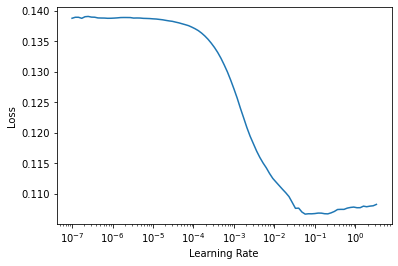

In [ ]:
l2.lr_find()

In [ ]:
l2.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,0.015613,0.015378,00:18
1,0.014453,0.014299,00:19
2,0.014103,0.013915,00:19
3,0.013683,0.013562,00:18
4,0.013607,0.013543,00:18


Let's unfreeze all layers and train them.

In [ ]:
l2.unfreeze()

In [ ]:
l2.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,0.013642,0.013651,00:18
1,0.013382,0.013282,00:18
2,0.013294,0.013129,00:18
3,0.013178,0.013031,00:19
4,0.013074,0.013030,00:19


In [ ]:
l2.path = Path('')

l2.save('models/02_cnn2_ep10')

Let's see if the model is improving.

In [ ]:
preds, targets, losses = l2.get_preds(with_loss=True)

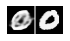

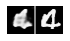

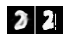

In [ ]:
_, indices = torch.sort(losses, descending=True)

for i in indices[:3]:
  show_image(torch.cat([preds, torch.ones(preds.shape[0],1,28,1), targets], dim=3)[i], cmap='Greys_r')

In [ ]:
I_preds = ((preds*100)-1)*(255/99)
I_targets = ((targets*100)-1)*(255/99)

I_error = torch.abs(I_preds - I_targets)

I_mean = torch.mean(I_error)
I_std = torch.std(I_error)

I_mean, I_std

(tensor(12.2046), tensor(26.7411))

Nice, the mean and the standard deviation decreased. Let's add a new layer.

Again, we keep everything but the last layer, and add two new layers (`Base` and `Head`).

In [ ]:
cnn3 = nn.Sequential(l2.model[0], l2.model[1], Base(8, 16), Head(16, 1, 1.1))
l3 = Learner(dls, cnn3, loss_func=F.mse_loss, model_dir='')

We freeze everything but the two last layers.

In [ ]:
l3.freeze_to(-2)

We find a good learning rate and train the model.

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0003981071640737355)

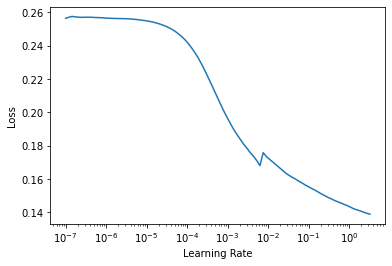

In [ ]:
l3.lr_find()

In [ ]:
l3.fit_one_cycle(5, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.012930,0.012544,00:19
1,0.011336,0.010928,00:19
2,0.010565,0.010285,00:19
3,0.010030,0.010060,00:19
4,0.009895,0.009768,00:19


Now we unfreeze all layers and train them all.

In [ ]:
l3.unfreeze()

In [ ]:
l3.fit_one_cycle(5, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.010616,0.010767,00:19
1,0.010378,0.010520,00:19
2,0.009992,0.009603,00:19
3,0.009642,0.009459,00:19
4,0.009406,0.009376,00:19


In [ ]:
l3.path = Path('')

l3.save('models/02_cnn3_ep10')

Nice, validation loss is under 0.01. Let's add more layers.

In [ ]:
cnn4 = nn.Sequential(l3.model[0], l3.model[1], l3.model[2], Base(16, 32), Head(32, 1, 1.1))
l4 = Learner(dls, cnn4, loss_func=F.mse_loss, model_dir='')

In [ ]:
l4.freeze_to(-2)

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0005754399462603033)

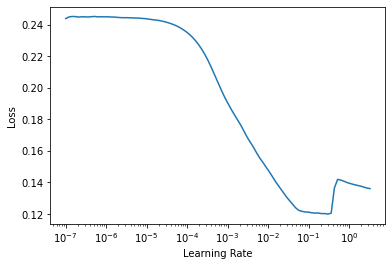

In [ ]:
l4.lr_find()

In [ ]:
l4.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,0.009254,0.009672,00:20
1,0.008698,0.008634,00:20
2,0.008317,0.008167,00:20
3,0.008171,0.007967,00:20
4,0.007987,0.007927,00:20


In [ ]:
l4.unfreeze()

In [ ]:
l4.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,0.008445,0.008203,00:20
1,0.008310,0.008244,00:19
2,0.008095,0.008137,00:20
3,0.007941,0.007829,00:19
4,0.007764,0.007718,00:19


The loss increased too much in the first epoches. This could be because the learning rate is too high for the first layers. Next, time we'll try something different.

In [ ]:
l4.path = Path('')

l4.save('models/02_cnn4_ep10')

Let's add more layers.

In [ ]:
cnn5 = nn.Sequential(*l4.model[0:4], Base(32, 64), Head(64, 1, 1.1))
l5 = Learner(dls, cnn5, loss_func=F.mse_loss, model_dir='')

In [ ]:
l5.freeze_to(-2)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0003981071640737355)

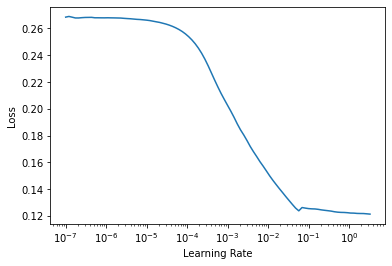

In [ ]:
l5.lr_find()

In [ ]:
l5.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,0.007929,0.007879,00:21
1,0.007663,0.007467,00:21
2,0.007260,0.007151,00:20
3,0.006991,0.006932,00:21
4,0.006843,0.006826,00:21


In [ ]:
l5.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=6.309573450380412e-07)

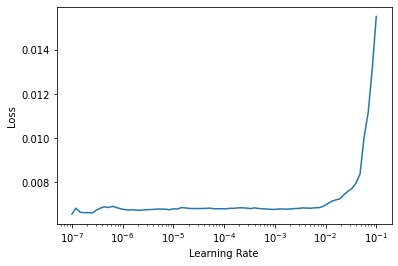

In [ ]:
l5.lr_find()

This time we train the model with different learning rates. The first layer is trained with `lr_max=1e-5` and the last with `lr_max=1e-3`. Intermediate layers are trained with intermediate values of `lr_max`. This is easily done with fastai by passing a *python slice* to `lr_max` argument.

In [ ]:
l5.fit_one_cycle(5, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,time
0,0.007022,0.006942,00:21
1,0.006975,0.006896,00:21
2,0.006920,0.006869,00:21
3,0.006785,0.006712,00:21
4,0.006744,0.006693,00:21


In [ ]:
l5.path = Path('')

l5.save('models/02_cnn5_std=0.1_ep10')

Validation loss was 0.0065 in part 1, we're very close. Let's add more layers.

In [ ]:
cnn6 = nn.Sequential(*l5.model[0:5], Base(64, 128), Head(128, 1, 1.1))
l6 = Learner(dls, cnn6, loss_func=F.mse_loss, model_dir='')

In [ ]:
l6.freeze_to(-2)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.00019054606673307717)

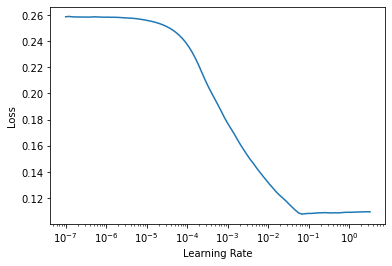

In [ ]:
l6.lr_find()

In [ ]:
l6.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,0.007262,0.007157,00:23
1,0.007013,0.006997,00:23
2,0.006735,0.006644,00:23
3,0.006336,0.006322,00:23
4,0.006169,0.006190,00:23


In [ ]:
l6.unfreeze()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=9.12010818865383e-07)

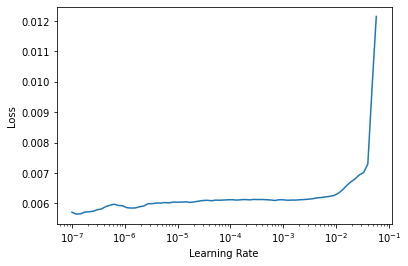

In [ ]:
l6.lr_find()

In [ ]:
l6.fit_one_cycle(5, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,time
0,0.006353,0.006404,00:23
1,0.006392,0.006440,00:23
2,0.006234,0.006220,00:23
3,0.006029,0.006085,00:23
4,0.005865,0.006039,00:23


In [ ]:
l6.path = Path('')

l6.save('models/02_cnn6_ep10')

We did it! Our validation loss is less than 0.0065, it is 0.0060.

## Results

Let's now check how good the predictions are.

In [ ]:
preds, targets, losses = l6.get_preds(with_loss=True)

On the left we show predictions that had the ten worst losses. On the right we show the targets.

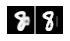

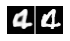

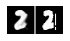

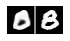

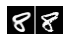

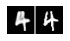

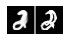

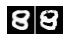

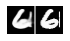

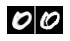

In [ ]:
_, indices = torch.sort(losses, descending=True)

for i in indices[:10]:
  show_image(torch.cat([preds, torch.ones(preds.shape[0],1,28,1), targets], dim=3)[i], cmap='Greys_r')

It seems nice, even the worst predictions could capture some details of the handwritten digits.

Let's calculate the same metrics we used in part 1.

In [ ]:
I_preds = ((preds*100)-1)*(255/99)
I_targets = ((targets*100)-1)*(255/99)

I_error = torch.abs(I_preds - I_targets)

I_mean = torch.mean(I_error)
I_std = torch.std(I_error)

I_mean, I_std

(tensor(6.7603), tensor(18.8619))

In part 1, the mean was 8.5 and the standard deviation was 19. Our new model got a mean equals to 6.7 and standard deviation equals to 18.9.

So we did it! We beat the model created in part 1, even though here we added noise in the data and, in part 1, we did not. Of course, we could try to keep improving the model. For instance, we could do some hyper-parameter tweaking, we could train the whole model at once, we could add more layers, etc. However, this is left as an exercise for the reader 😆.